### Bar Kinematics

Replotting bar cross-sections to get more kinematic measurements during time of deposition. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from shapely.geometry import Polygon, MultiPolygon
import seaborn as sns
import scipy.stats as stats

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
folnam = 'agubh2_PBT'
init = f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/{folnam}'

##### Define formulae for calculating trajectories

In [2]:
## using cos rule to calculate bearing angles instead
## impose a limit on the y axis to create a y axis vector
def dist_between(x1, y1, x2, y2):
    '''find the euclidean distance between two coordinates'''
    d = np.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

def angle_between(ax, ay, bx, by, ox = 0, oy = 0):
    
    '''find the angle between two vectors in centroid space, i.e. the deviation from the growth trajectory'''

    ##find the lengths of all the sides of the triangle
    oa = dist_between(ox, oy, ax, ay)
    ob = dist_between(ox, oy, bx, by)
    ab = dist_between(ax, ay, bx, by)
        
    #use cosing rule to get the bearing
    cos_theta = (oa**2+ob**2-ab**2)/(2*oa*ob)
    bear = np.rad2deg(np.arccos(cos_theta))
    #if bx < ax:
    #    bear = 360-bear
    return bear

def tan_bearing(ax, ay, bx, by):
    ''' find the bearing using tan instead of the cos rule'''
    dx = bx-ax
    dz = by-ay
    
    
    ## account for the differences in sngle based on the quadrant
    # Q1
    if np.logical_and(bx>ax, by>ay): 
        theta = np.rad2deg(np.arctan(dx/dz))
    # Q4
    elif np.logical_and(bx>ax, by<ay): 
        alpha = np.rad2deg(np.arctan(dz/dx))
        theta = 90 + abs(np.rad2deg(np.arctan(alpha))) ## because alpha will be negative
    # Q2
    elif np.logical_and(bx<ax, by>ay): 
        alpha = np.rad2deg(np.arctan(dz/dx))
        theta = 270 + abs(alpha) ## because alpha will be negative 
    # Q3
    else: 
        alpha = np.rad2deg(np.arctan(dz/dx))
        theta = 270- abs(alpha)

    if theta > 360:
        print(f'ERROR: ({ax, ay}, {bx, by})')
    return theta

Get thickness distribution of bars for Sinead CVs

In [3]:
thicknessCVs = pd.DataFrame(columns = ['File', '1mCV', '1mcount', '1mmean', '1msd', 
                                       '2mCV', '2mcount', '2mmean', '2msd',
                                       '5mCV', '5mcounts', '5mmean', '5msd',
                                       '10mCV', '10mcounts', '10mmean', '10msd'])
allthick = np.array([])
for root, dirs, files in os.walk(init):
    for file in files:
        xy_topo = np.load(os.path.join(root, file), allow_pickle = True)[:, :, 0]
        thickness = xy_topo[-1, :]-xy_topo[0, :]
        allthick = np.append(allthick, thickness)
        
        cvdata = pd.DataFrame(np.reshape(np.array([file, 
                          stats.variation(thickness),
                           len(thickness),
                           np.nanmean(thickness), 
                           np.std(thickness),
                          [stats.variation(thickness[::2]) if len(thickness) > 2 else np.nan()], 
                           [len(thickness[::2]) if len(thickness) > 2 else np.nan()],
                           [np.nanmean(thickness[::2]) if len(thickness) > 2 else np.nan()], 
                           [np.std(thickness[::2]) if len(thickness) > 2 else np.nan()],
                          [stats.variation(thickness[::5]) if len(thickness) > 5 else np.nan()],
                           [len(thickness[::5]) if len(thickness) > 2 else np.nan()],
                           [np.nanmean(thickness[::5]) if len(thickness) > 2 else np.nan()], 
                           [np.std(thickness[::5]) if len(thickness) > 2 else np.nan()],
                          [stats.variation(thickness[::10]) if len(thickness) > 10 else np.nan()],
                           [len(thickness[::10]) if len(thickness) > 2 else np.nan()],
                           [np.nanmean(thickness[::10]) if len(thickness) > 2 else np.nan()], 
                           [np.std(thickness[::10]) if len(thickness) > 2 else np.nan()]
                          ]), (1, 17)), columns = ['File', '1mCV', '1mcount', '1mmean', '1msd', 
                                                   '2mCV', '2mcount', '2mmean', '2msd',
                                                   '5mCV', '5mcounts', '5mmean', '5msd',
                                                   '10mCV', '10mcounts', '10mmean', '10msd'])
        thicknessCVs = pd.concat([thicknessCVs, cvdata])
# thicknessCVs.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/DWN-LysterthicknessCVs.csv')

/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_42633/359890209.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cvdata = pd.DataFrame(np.reshape(np.array([file,
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_42633/359890209.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cvdata = pd.DataFrame(np.reshape(np.array([file,
/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_42633/359890209.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

In [4]:
thicknessCVs

,File,1mCV,1mcount,1mmean,1msd,2mCV,2mcount,2mmean,2msd,5mCV,5mcounts,5mmean,5msd,10mCV,10mcounts,10mmean,10msd
0,1500-2100-FP-3-6.npy,0.798913,47,1.062904,0.849168,[0.8151318983115502],[24],[1.043585035401299],[0.8506594509561871],[0.8391990858010139],[10],[1.0117153708228384],[0.8490306142853598],[0.8658166096338109],[5],[0.9984284090267529],[0.864455900065623]
0,1500-2100-FP-4-8.npy,0.767947,48,0.415375,0.318986,[0.7663407630824904],[24],[0.41560262962679234],[0.3184932363272857],[0.8018195661183133],[10],[0.4002401189975971],[0.3209203585577954],[0.8337903265437231],[5],[0.4023219243579906],[0.33545212868614804]
0,1500-2100-FP-5-7.npy,0.437075,18,0.529601,0.231475,[0.45782465696859553],[9],[0.5239737669798128],[0.2398881101280756],[0.5431013729709234],[4],[0.49259203446083255],[0.2675274102302186],[0.837036800866292],[2],[0.41757734614928216],[0.34952760593503135]
0,1500-2100-P-5-13.npy,0.886086,32,0.2378,0.210712,[0.8690916124779114],[16],[0.24001216207310688],[0.20859255695042628],[0.9431942939941135],[7],[0.2235648033547102],[0.21086504686207871],[1.1081919942936187],[4],[0.20958823759726342],[0.23226400700339614]
0,1500-2100-PP-3-10.npy,0.757953,60,0.768378,0.582394,[0.7610680343202489],[30],[0.7669650899085617],[0.5837126133689621],[0.7746230201060682],[12],[0.7586751846854819],[0.587687262840597],[0.8366284547989461],[6],[0.715477449172857],[0.5985887927449789]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,975-1575-TR-4-14.npy,0.731992,27,0.454887,0.332974,[0.7747213718939755],[14],[0.43747039892293155],[0.33891766761657827],[0.8833874244729928],[6],[0.4040289067118197],[0.35691405531279347],[1.0104403747095283],[3],[0.38730268659479267],[0.3913462717688493]
0,975-1575-TR-4-8.npy,0.697755,121,0.824444,0.57526,[0.7022837874987657],[61],[0.8194801540074833],[0.5755076263364473],[0.7148555716813079],[25],[0.8087561949257522],[0.5781438720744478],[0.6982500604495635],[13],[0.8046858466648145],[0.5618719410766149]
0,975-1575-TR-5-0.npy,0.488057,27,0.506878,0.247385,[0.5303405917808252],[14],[0.48880193863399574],[0.2592315093987679],[0.624034974863331],[6],[0.44789835125661853],[0.27950423636775135],[0.6566071708919302],[3],[0.45728049123574926],[0.3002536496543774]
0,975-1575-TR-5-16.npy,0.531548,33,0.776942,0.412982,[0.5550741379116068],[17],[0.7577786538888719],[0.4206233330351834],[0.6218774856700765],[7],[0.7321154633029503],[0.45528612353902187],[0.7954655049977579],[4],[0.6169788317734022],[0.4907853779895561]


<AxesSubplot:ylabel='1mCV'>

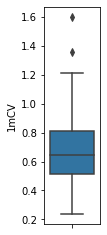

In [5]:
cvs = thicknessCVs['1mCV']
plt.figure(figsize = (1, 4))
sns.boxplot(y = cvs, showfliers = True)


In [6]:
np.mean(allthick)

0.5705950918734487

<AxesSubplot:ylabel='Count'>

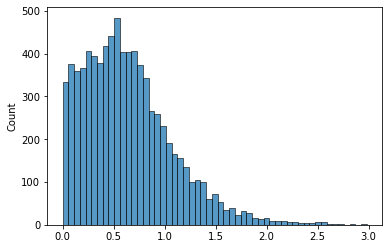

In [7]:
sns.histplot(allthick[allthick>0])

Get trajectories of centroids

In [18]:
skew_store = pd.DataFrame(columns = ['File', 'Skewness'])
init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/agubh2-100m copy'
c = 0
for root, dirs, files in os.walk(init):
    for file in files:
        c += 1

In [19]:
c

769

In [ ]:
skew_store = pd.DataFrame(columns = ['File', 'Skewness'])
init = '/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays/agubh2-100m-mmp'
for root, dirs, files in os.walk(init):
    for file in files:
        xy_topo = np.load(os.path.join(root, file), allow_pickle = True)[:, :, 0]
        # print(xy_topo.shape, file)
        posnew = np.arange(0, xy_topo.shape[1], dtype = 'float')

        posnew_nb = np.insert(posnew, 0, np.nan)
        posnew_nb = np.concatenate((posnew_nb, np.array([np.nan])), axis = 0)

        ## make nan border for the topo array
        nan_border = np.empty([len(xy_topo), 1])
        nan_border[:] = np.nan

        ## make nan borders for all of it
        SIC_startcrop = copy.deepcopy(xy_topo)
        SIC_startcrop = np.concatenate((nan_border, SIC_startcrop, nan_border), axis = 1)

        SIC_startcrop = np.delete(SIC_startcrop, 0, axis = 0)
        SIC_startcrop.shape

        SIC_endcrop = copy.deepcopy(xy_topo)
        SIC_endcrop = np.concatenate((nan_border, SIC_endcrop, nan_border), axis = 1)

        SIC_endcrop = np.delete(SIC_endcrop, -1, axis=0)
        SIC_endcrop.shape

        delta = SIC_startcrop-SIC_endcrop

        delta[np.where(delta[:]==0)] = np.nan

        #print(len(posnew_nb))
        #l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
        l_idx = np.empty([1,]) #index value of left edge
        #r_edges = np.empty([1,]) #right edge of the wheeler fill
        r_idx = np.empty([1,]) #index value of right edge
        surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
        for i in range (0, len(delta)):
            #if ~np.isnan(deposurf[i, 0]):
            #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

            for xpos in range (0, len(posnew_nb)-1):
                l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
                r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
                #print(xpos, 'L', l_edge)
                #print(xpos, 'R', r_edge)
                if l_edge == True:
                    #l_edges = np.append(l_edges, [posnew_nb[xpos+1]], axis = 0)
                    l_idx = np.append(l_idx, [xpos], axis = 0)
                    #print(posnew_nb[xpos+1], 'potato')
                    surf_age = np.append(surf_age, [i], axis = 0)
                if r_edge == True:
                    #print(xpos, 'tomato')
                    #r_edges = np.append(r_edges, [posnew_nb[xpos-1]], axis = 0)
                    r_idx = np.append(r_idx, [xpos], axis = 0)

        #surf_age = np.append(surf_age, [i+1], axis = 0)
        #print('L', l_edges)
        #print('R',r_edges)
        #print(dep_age)

        l_idx = np.reshape(l_idx, [len(l_idx), 1])
        #l_index = np.delete(l_index, 1)

        l_idx = l_idx.astype(int)
        r_idx = np.reshape(r_idx, [len(r_idx), 1])
        #r_index = np.delete(r_index, 1)
        r_idx = r_idx.astype(int)

        #print(l_idx[:, 0], r_idx[:, 0])
        surf_age = np.reshape(surf_age, [len(surf_age), 1])

        # print(l_idx.shape, r_idx.shape, surf_age.shape)

        vertices_b = surf_age
        vertices_b = np.append(vertices_b, l_idx, axis = 1)
        vertices_b = np.append(vertices_b, r_idx, axis = 1)

        #print(vertices)#, vertices.shape)


        cent_array = np.empty([len(vertices_b), 8])
        cent_array[:] = np.nan

        ## Plot the filled stratigraphy, create a polygon for each, find the centroid, store the centroid and its age
        testfig, ax1 = plt.subplots(1, 1)
        poly_data = {}
        for i in range (1, len(vertices_b)):
            time = int(vertices_b[i, 0])
            left = int(vertices_b[i, 1])
            right = int(vertices_b[i, 2])

            poly = ax1.fill_between(posnew[left:right], xy_topo[time, left:right], xy_topo[time+1, left:right])
            pverts = poly.get_paths()[0].vertices

            polygon = Polygon(pverts) #create a shapely polygon
            #print(polygon)
            poly_data[i] = polygon
            area = polygon.area
            bounds = polygon.bounds
            #print(type(bounds[0]))
            cent_array[i, 4] = bounds[0]
            cent_array[i, 5] = bounds[1]
            cent_array[i, 6] = bounds[2]
            cent_array[i, 7] = bounds[3]
            cent_array[i, 3] = area
            ctroid = polygon.centroid
            cent_array[i, 0] = time
            cent_array[i, 1] = ctroid.x
            cent_array[i, 2] = ctroid.y
        plt.close(testfig)

        ## centroids = time, xcord, ycord, boundaries
        trajectories = np.empty([len(cent_array), 1]) ## make storage array
        for i in range (1, len(trajectories)):
            trajectories[i] = angle_between(cent_array[i-1, 1], cent_array[i-1, 2], cent_array[i, 1], cent_array[i, 2])
        # trajectories = np.delete(trajectories, 0)
        traj_kurt = pd.DataFrame(np.reshape(np.array([file, stats.skew(trajectories[~np.isnan(trajectories)])]), (1, 2)), columns = ['File', 'Skewness'])
        skew_store = pd.concat([skew_store, traj_kurt])
        # print(cent_array.shape)

In [125]:
skew_store.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/CentroidTrajectories_Skew.csv')

In [108]:
skew_store = pd.DataFrame(columns = ['File', 'Skewness'])

In [109]:
testdf = pd.DataFrame(np.reshape(np.array([file, stats.skew(trajectories[~np.isnan(trajectories)])]), (1, 2)), columns = ['File', 'Skewness'])

In [110]:
skew_store = pd.concat([skew_store, testdf])

In [111]:
skew_store

,File,Skewness
0,690-TR-2-5.npy,5.192610571718467
